# Smooth the Distribution Parameters
Our data contain a lot of noise originating from our ability to detect voids, especially small ones. 
Changes in focal plane change make voids disapper, microscope drift can move them offscreen, and changes in imaging settings make them easier or harder to detect. 
So, we need to apply noise reduction to get a reliable signal how of the parameters for void distributions change over time.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd

To-do: 
1. Implement a median-pass filter first
1. At least, drop the "zero-valued" frames
1. Also mark when the frame has moved

# Load in the data
We computed values for the distributions in the last notebook

In [2]:
data = pd.read_csv('data/fitted-distributions.csv')

## Start with a median filter
To get rid of the major outliers

In [3]:
subset = data.query('temp==550.')  # Get a subset of our data, all taken at the same temperature

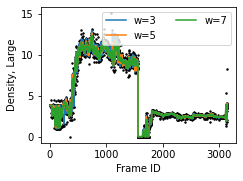

In [4]:
window_size = [3, 5, 7]

fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(subset['frame_id'], subset['density_large'], s=2, color='k')

for ws in window_size:
    new_signal = signal.medfilt(subset['density_large'], ws)
    ax.plot(subset['frame_id'], new_signal, label=f'w={ws}')
    
#ax.set_xlim(1000, 1100)
#ax.set_ylim(0, 15)

ax.set_xlabel('Frame ID')
ax.set_ylabel('Density, Large')

ax.legend(ncol=2)

A window size of 5 seems to be sufficient for the median pass

## Test out a smoothing filter
We are going to use [Savitzky-Golay Filters](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) work well for smoothing our distributions. We just need to find a reasonable set of parameters

Let's fit our data with a cubic polynomial so that we have smooth 1st and 2nd derivatives, which means we just need to vary window size

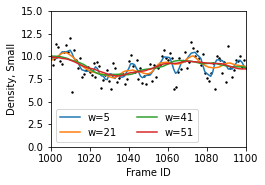

In [5]:
window_size = [5, 21, 41, 51]

fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(subset['frame_id'], subset['density_small'], s=2, color='k')

for ws in window_size:
    median_pass = signal.medfilt(subset['density_small'], 5)
    new_signal = signal.savgol_filter(median_pass, ws, 3)
    ax.plot(subset['frame_id'], new_signal, label=f'w={ws}')
    
ax.set_xlim(1000, 1100)
ax.set_ylim(0, 15)

ax.set_xlabel('Frame ID')
ax.set_ylabel('Density, Small')

ax.legend(ncol=2)

It seems that window size around 51, or possibly greater, is needed to smooth enough to get reasonable derivatives.

### Run the smoothing
Run it on all subsets, on all columns and produce the derivatives as well

In [6]:
smooth_data = data.copy()

In [7]:
subsets = set(data['source'])
print(f'Found {len(subsets)} data subsets')

Found 3 data subsets


Prepare storage for the derivates

In [8]:
cols = data.columns[-6:]
for col in cols:
    smooth_data[col + '_dt'] = 0

Run the filtering on each column of each dataset

In [9]:
for subset_name in subsets:
    subset = smooth_data.query(f'source=="{subset_name}"')
    for col in cols:
        median_pass = signal.medfilt(subset[col], 5)
        smoothed = signal.savgol_filter(median_pass, window_length=101, polyorder=3)
        smoothed_dt = signal.savgol_filter(median_pass, window_length=101, polyorder=3, deriv=1)
        smooth_data.loc[subset.index, col] = smoothed
        smooth_data.loc[subset.index, col + '_dt'] = smoothed_dt

Plot the derivative to show it worked

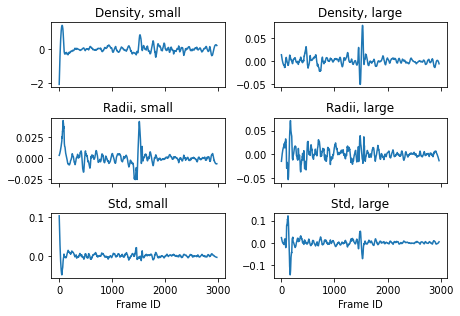

In [10]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(6.5, 4.5))

subset = smooth_data.query('temp==575')
for col, ax in zip(cols, axs.flatten()):
    ax.plot(subset['frame_id'], subset[col + '_dt'])
    ax.set_title(col.capitalize().replace("_", ", "))
    

for ax in axs[-1, :]:
    ax.set_xlabel('Frame ID')
fig.tight_layout()

The derivatives are kind of noisy, but we'll how it it goes

In [11]:
smooth_data.to_csv('data/fitted-distributions_smoothed.csv', index=False)